In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2


# PRE PROCESSING

In [2]:
DATA_PATH = '../input/infrared-solar-modules/2020-02-14_InfraredSolarModules/InfraredSolarModules'
METADATA_PATH = os.path.join(DATA_PATH, 'module_metadata.json')

In [3]:
df = pd.read_json(METADATA_PATH, orient='index').sort_index()
df['image_filepath'] = df.image_filepath.apply(lambda x: os.path.join(DATA_PATH, x))
df

,image_filepath,anomaly_class
0,../input/infrared-solar-modules/2020-02-14_Inf...,Offline-Module
1,../input/infrared-solar-modules/2020-02-14_Inf...,Offline-Module
2,../input/infrared-solar-modules/2020-02-14_Inf...,Offline-Module
3,../input/infrared-solar-modules/2020-02-14_Inf...,Offline-Module
4,../input/infrared-solar-modules/2020-02-14_Inf...,Offline-Module
...,...,...
19995,../input/infrared-solar-modules/2020-02-14_Inf...,No-Anomaly
19996,../input/infrared-solar-modules/2020-02-14_Inf...,No-Anomaly
19997,../input/infrared-solar-modules/2020-02-14_Inf...,No-Anomaly
19998,../input/infrared-solar-modules/2020-02-14_Inf...,No-Anomaly



Unique values and their frequency:
anomaly_class
No-Anomaly        10000
Cell               1877
Vegetation         1639
Diode              1499
Cell-Multi         1288
Shadowing          1056
Cracking            940
Offline-Module      827
Hot-Spot            249
Hot-Spot-Multi      246
Soiling             204
Diode-Multi         175
Name: count, dtype: int64


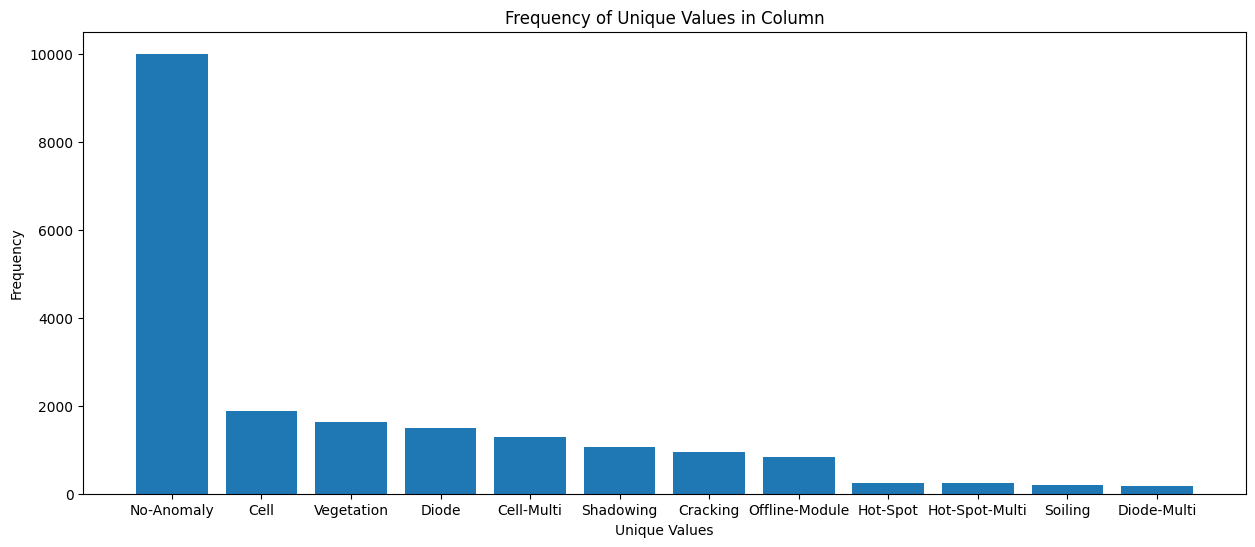

In [4]:
# Get unique values and their frequency
unique_values = df['anomaly_class'].value_counts()
print("\nUnique values and their frequency:")
print(unique_values)

# Set the figure size
plt.figure(figsize=(15, 6))

# Plot the bar chart
plt.bar(unique_values.index, unique_values.values)

# Set labels and title

plt.xlabel('Unique Values')
plt.ylabel('Frequency')
plt.title('Frequency of Unique Values in Column')

# Show the plot
plt.show()

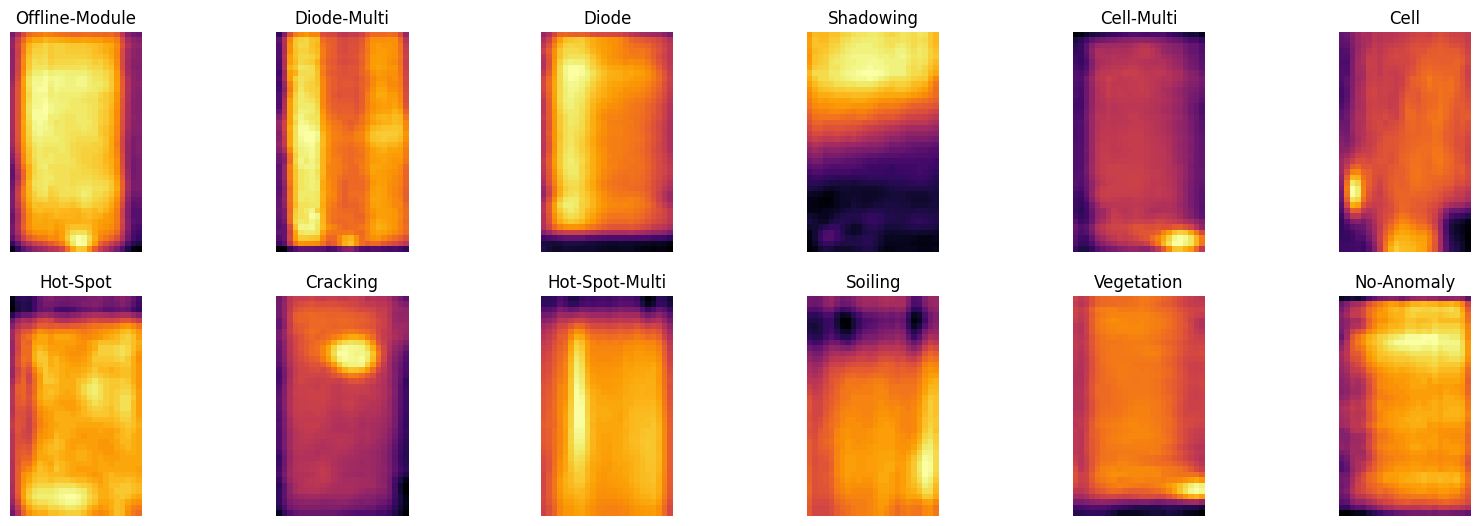

In [5]:

# Get unique anomaly classes
unique_classes = df['anomaly_class'].unique()

# Plot the sampled images
plt.figure(figsize=(20, 20))

for i, class_name in enumerate(unique_classes, start=1):
    # Sample one image for each class
    sample = df[df['anomaly_class'] == class_name].sample(n=1).iloc[0]
    
    image = cv2.imread(sample['image_filepath'], 0)
    
    plt.subplot(6, 6, i)
    plt.imshow(image, cmap='inferno')
    plt.title(class_name)
    plt.axis('off')

plt.show()

**Splitting images based on module properties**

As mentioned in readme of the dataset, the classes Hot-spot and Hot-spot Multi are anomalies from Thin film modules. These types of solar panels are less used in the industry when compared to (monocrystalline or polycrystalline) silicon modules and work completely different. But neither in Raptor maps github repository or in the dataset paper there is information about how many modules belong to the crystalline type and how much to the thin film type in the No-Anomaly class.

In [6]:
crystal_df = df.query('anomaly_class != ("Hot-Spot", "Hot-Spot-Multi")')
crystal_df

,image_filepath,anomaly_class
0,../input/infrared-solar-modules/2020-02-14_Inf...,Offline-Module
1,../input/infrared-solar-modules/2020-02-14_Inf...,Offline-Module
2,../input/infrared-solar-modules/2020-02-14_Inf...,Offline-Module
3,../input/infrared-solar-modules/2020-02-14_Inf...,Offline-Module
4,../input/infrared-solar-modules/2020-02-14_Inf...,Offline-Module
...,...,...
19995,../input/infrared-solar-modules/2020-02-14_Inf...,No-Anomaly
19996,../input/infrared-solar-modules/2020-02-14_Inf...,No-Anomaly
19997,../input/infrared-solar-modules/2020-02-14_Inf...,No-Anomaly
19998,../input/infrared-solar-modules/2020-02-14_Inf...,No-Anomaly


In [7]:
thin_film_df = df.query('anomaly_class == ("Hot-Spot", "Hot-Spot-Multi")')
thin_film_df

,image_filepath,anomaly_class
6722,../input/infrared-solar-modules/2020-02-14_Inf...,Hot-Spot
6723,../input/infrared-solar-modules/2020-02-14_Inf...,Hot-Spot
6724,../input/infrared-solar-modules/2020-02-14_Inf...,Hot-Spot
6725,../input/infrared-solar-modules/2020-02-14_Inf...,Hot-Spot
6726,../input/infrared-solar-modules/2020-02-14_Inf...,Hot-Spot
...,...,...
8152,../input/infrared-solar-modules/2020-02-14_Inf...,Hot-Spot-Multi
8153,../input/infrared-solar-modules/2020-02-14_Inf...,Hot-Spot-Multi
8154,../input/infrared-solar-modules/2020-02-14_Inf...,Hot-Spot-Multi
8155,../input/infrared-solar-modules/2020-02-14_Inf...,Hot-Spot-Multi


**MODEL FOR PREDICTION**

In [8]:
crystal_df['image_filepath']

0        ../input/infrared-solar-modules/2020-02-14_Inf...
1        ../input/infrared-solar-modules/2020-02-14_Inf...
2        ../input/infrared-solar-modules/2020-02-14_Inf...
3        ../input/infrared-solar-modules/2020-02-14_Inf...
4        ../input/infrared-solar-modules/2020-02-14_Inf...
                               ...                        
19995    ../input/infrared-solar-modules/2020-02-14_Inf...
19996    ../input/infrared-solar-modules/2020-02-14_Inf...
19997    ../input/infrared-solar-modules/2020-02-14_Inf...
19998    ../input/infrared-solar-modules/2020-02-14_Inf...
19999    ../input/infrared-solar-modules/2020-02-14_Inf...
Name: image_filepath, Length: 19505, dtype: object

In [9]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(crystal_df, train_size=0.8, shuffle=True, random_state=1)

In [10]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalAveragePooling2D

In [11]:
import tensorflow as tf  # Import TensorFlow

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)


In [12]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_filepath',
    y_col='anomaly_class',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_filepath',
    y_col='anomaly_class',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)


Found 12484 validated image filenames belonging to 10 classes.
Found 3120 validated image filenames belonging to 10 classes.


In [13]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_filepath',
    y_col='anomaly_class',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 3901 validated image filenames belonging to 10 classes.


# RESNET 50

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Concatenate, LayerNormalization, MultiHeadAttention, Dropout
from tensorflow.keras.models import Model

# Load VGG16 model for Query (Q) without the top classification layer
vgg16_model = tf.keras.applications.VGG16(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# Load VGG19 model for Key (K) without the top classification layer
vgg19_model = tf.keras.applications.VGG19(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# Load ResNet50 model for Value (V) without the top classification layer
resnet50_model = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# Freeze layers if not fine-tuning
vgg16_model.trainable = False
vgg19_model.trainable = False
resnet50_model.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
from tensorflow.keras.layers import Lambda, Dense, MultiHeadAttention, Concatenate, Flatten

# Define input
inputs = tf.keras.Input(shape=(224, 224, 3))

# Extract features using each model
key_features = vgg16_model(inputs)
value_features = vgg19_model(inputs)
query_features = resnet50_model(inputs)

# Align dimensions using Dense layers
key = Dense(512)(key_features)   # Match the dimensions
value = Dense(512)(value_features)
query = Dense(512)(query_features)

# Expand dimensions for compatibility with attention layer
key = Lambda(lambda x: tf.expand_dims(x, axis=1))(key)
value = Lambda(lambda x: tf.expand_dims(x, axis=1))(value)
query = Lambda(lambda x: tf.expand_dims(x, axis=1))(query)

# Define MHA with 8 heads
mha_layer = MultiHeadAttention(num_heads=8, key_dim=512)
attention_output = mha_layer(query=query, key=key, value=value)

# Reshape the attention output to match the rank of other features
attention_output = Lambda(lambda x: tf.squeeze(x, axis=1))(attention_output)

# Concatenate the output with the initial input features
concat_features = Concatenate()([attention_output, key_features, value_features, query_features])

# Add custom classification layers
x = Dense(128, activation='relu')(concat_features)
x = Dense(50, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)

# Define final model
model = tf.keras.Model(inputs, outputs)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Lambda, Dense, MultiHeadAttention, Concatenate, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, precision_score, recall_score
import numpy as np


In [17]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, precision_score, recall_score
import numpy as np

# Define ModelCheckpoint to save the best model
# Define ModelCheckpoint callback to save the best model
checkpoint_callback = ModelCheckpoint(
    "best_model.keras",  # Changed to .keras
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)


# Define EarlyStopping to stop training when validation accuracy stops improving
early_stopping_callback = EarlyStopping(
    monitor="val_accuracy",
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restores the best weights after stopping
    verbose=1
)

# Train the model with early stopping
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=200,
    batch_size=32,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

# Load the best model after training
# Load the best model after training
model.load_weights("best_model.keras")


# Evaluate on test set
results = model.evaluate(test_images, verbose=0)
print(f"Test Loss: {results[0]:.4f}, Test Accuracy: {results[1] * 100:.2f}%")

# Get predictions for the test set
y_pred_prob = model.predict(test_images)
y_pred_labels = np.argmax(y_pred_prob, axis=1)
y_true_labels = test_images.classes

# Calculate precision, recall, and other classification metrics
print("\nClassification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=test_images.class_indices.keys()))

# Precision and recall as separate metrics
precision = precision_score(y_true_labels, y_pred_labels, average="weighted")
recall = recall_score(y_true_labels, y_pred_labels, average="weighted")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")


Epoch 1/200


/opt/conda/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1730143143.673377      79 service.cc:145] XLA service 0x7be518003170 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730143143.673437      79 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/391 ━━━━━━━━━━━━━━━━━━━━ 2:43:01 25s/step - accuracy: 0.0625 - loss: 2.2207

I0000 00:00:1730143157.467870      79 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.4896 - loss: 1.7025
Epoch 1: val_accuracy improved from -inf to 0.55641, saving model to best_model.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 132s 273ms/step - accuracy: 0.4897 - loss: 1.7021 - val_accuracy: 0.5564 - val_loss: 1.3768
Epoch 2/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.5686 - loss: 1.3215
Epoch 2: val_accuracy improved from 0.55641 to 0.58782, saving model to best_model.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 109s 225ms/step - accuracy: 0.5686 - loss: 1.3214 - val_accuracy: 0.5878 - val_loss: 1.2401
Epoch 3/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.6125 - loss: 1.2073
Epoch 3: val_accuracy improved from 0.58782 to 0.65128, saving model to best_model.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 88s 225ms/step - accuracy: 0.6125 - loss: 1.2072 - val_accuracy: 0.6513 - val_loss: 1.1377
Epoch 4/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.6529 - loss: 1.0991
Epoch 4: val_accuracy improved

/opt/conda/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


122/122 ━━━━━━━━━━━━━━━━━━━━ 28s 198ms/step

Classification Report:
                precision    recall  f1-score   support

          Cell       0.59      0.49      0.54       391
    Cell-Multi       0.53      0.37      0.43       283
      Cracking       0.70      0.75      0.72       186
         Diode       0.76      0.80      0.78       300
   Diode-Multi       0.68      0.35      0.46        43
    No-Anomaly       0.84      0.96      0.89      1915
Offline-Module       0.55      0.42      0.48       172
     Shadowing       0.78      0.53      0.63       220
       Soiling       0.41      0.37      0.39        30
    Vegetation       0.67      0.66      0.67       361

      accuracy                           0.76      3901
     macro avg       0.65      0.57      0.60      3901
  weighted avg       0.74      0.76      0.75      3901

Weighted Precision: 0.7430
Weighted Recall: 0.7588


In [18]:
print(" ")